<a href="https://colab.research.google.com/github/hwon-n/section4_project/blob/main/curse_filtering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 욕설 감지 프로젝트

데이터셋 주소: [2runo github](https://github.com/2runo/Curse-detection-data)

In [ ]:
pip install beautifulsoup4

In [ ]:
pip install requests

In [39]:
import os
root = '/content/drive/MyDrive/curse_dataset.txt'

txt_file = open(root, encoding = 'utf-8')

curse = []
for txt in txt_file:
  txt = txt.replace('\n', '')
  text, label = txt.split('|', 1)
  curse.append([text, label])

len(curse)

5856

In [ ]:
# LoL 인벤 자유게시판 제목 스크래핑
import requests
from bs4 import BeautifulSoup

titles = []

url = 'https://www.inven.co.kr/board/lol/4626?p='
for i in range(1, 21):
  response = requests.get(url+str(i))
  if response.status_code == 200:
    html = response.text
    soup = BeautifulSoup(html, 'html.parser')
    title = soup.find_all('a', class_='subject-link')
    for i in title:
      i = i.get_text()
      i = i[5:]
      i = i.strip()
      if len(i) > 2:
        titles.append(i)

In [ ]:
len(titles)

1339

In [ ]:
# 파일 저장

path = '/content/drive/MyDrive/inven_data.txt'
with open(path, 'w', encoding = 'utf-8') as f:
  for title in titles:
    f.write(title+ '|1\n')

print('저장 완료')

저장 완료


# 데이터 확인

In [36]:
# 데이터 불러오기

path = '/content/drive/MyDrive/inven_data.txt'
inven_file = open(path, encoding='utf-8')
inven_data = []

for text in inven_file:
  text = text.replace('\n', '')
  text, label = text.split('|', 1)
  inven_data.append([text, label])

inven_data = inven_data[4:]

In [37]:
len(inven_data)

1385

In [40]:
inven_data.extend(curse)
inven_data[1555]

['그럼 20분짜리영상 매일올리면 한달에 600임?', '0']

In [41]:
import pandas as pd

df = pd.DataFrame(inven_data, columns = ['text', 'label'])
df.head(4)

,text,label
0,임동규가 추신수보다 잘함?,0
1,은가누 vs 청소년기 고릴라,0
2,Twitch산점 pm9시 칼바람 시참내전 놀러와요!,0
3,Lck 해리포터 비유.,0


In [42]:
df.label.value_counts()

0                                                                                                                                                                                                                           4819
1                                                                                                                                                                                                                           2421
 한경닷컴 - 한국경제여자 형제가 인생을 더 행복하게 만든다 - 동아일보여자 형제 없는 남성을 선호한다?_채널A_웰컴투시월드 16회여자형제와 너무 친한 남친, 이건 정말 싫어 - 싱글즈여자형제 많은 사람의 특징이 뭔가요? - - ::: 알찬살림 요리정보 ...여자형제있는 사람이 눈치빠린거 같지않나요? - - ::: 알찬살림 ...여자 형제 있는 남돌과 없는 남돌의 차이 : 네이트판|0       1
Name: label, dtype: int64

In [43]:
# 잘못 분류된 label을 가진 데이터 제거

index = df.loc[df.label.str.contains('한경닷컴')].index[0]
df = df.drop(index)
df.label.value_counts()

0    4819
1    2421
Name: label, dtype: int64

In [44]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size = 0.3, stratify=df['label'])
train.label.value_counts()

0    3373
1    1695
Name: label, dtype: int64

In [45]:
test.label.value_counts()

0    1446
1     726
Name: label, dtype: int64

In [46]:
# train, test 데이터 tsv 파일로 저장

train.to_csv('/content/drive/MyDrive/train.tsv', sep = '\t', index = None)
test.to_csv('/content/drive/MyDrive/test.tsv', sep = '\t', index = None)

# 모델 학습 (KoBERT)

In [1]:
pip install git+https://git@github.com/SKTBrain/KoBERT.git@master

  Cloning https://****@github.com/SKTBrain/KoBERT.git (to revision master) to /tmp/pip-req-build-8y9dlv5w
  Running command git clone -q 'https://****@github.com/SKTBrain/KoBERT.git' /tmp/pip-req-build-8y9dlv5w


In [2]:
pip install transformers

In [47]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
import numpy as np
from tqdm.notebook import tqdm

from kobert import get_tokenizer, get_pytorch_kobert_model

from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup

In [49]:
# data load
train_dataset = nlp.data.TSVDataset('/content/drive/MyDrive/train.tsv', num_discard_samples = 1)
test_dataset = nlp.data.TSVDataset('/content/drive/MyDrive/test.tsv', num_discard_samples = 1)

In [50]:
device = torch.device("cuda:0")

In [51]:
bertmodel, vocab = get_pytorch_kobert_model()

using cached model. /content/.cache/kobert_v1.zip
using cached model. /content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


In [52]:
tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

using cached model. /content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


In [53]:
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, max_len,
                 pad, pair):
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len, pad=pad, pair=pair)

        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))


In [54]:
max_len = 128
batch_size = 32
warmup_ratio = 0.1
num_epochs = 10
max_grad_norm = 1
log_interval = 200
learning_rate =  0.00001

In [55]:
data_train = BERTDataset(train_dataset, 0, 1, tok, max_len, True, False)
data_test = BERTDataset(test_dataset, 0, 1, tok, max_len, True, False)

In [56]:
train_dataloader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, num_workers=5)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, num_workers=5)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [57]:
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes=2,
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
                 
        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)
    
    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
        if self.dr_rate:
            out = self.dropout(pooler)
        else:
            out = pooler
        return self.classifier(out)

In [58]:
model = BERTClassifier(bertmodel,  dr_rate=0.5).to(device)

In [59]:
# Prepare optimizer and schedule (linear warmup and decay)
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

In [60]:
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [61]:
t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

In [62]:
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

In [63]:
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

데이터셋 수정 전
learning_rate = 0.00001
batch_size = 32
max_len = 128

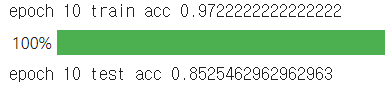

데이터셋 수정 후 

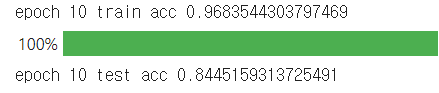

데이터셋 재수정 후

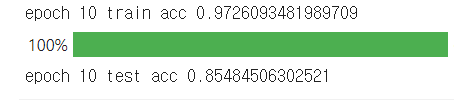

In [64]:
for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))
    model.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in tqdm(enumerate(test_dataloader), total=len(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        test_acc += calc_accuracy(out, label)
    print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


  0%|          | 0/159 [00:00<?, ?it/s]

epoch 1 batch id 1 loss 0.6603183746337891 train acc 0.65625
epoch 1 train acc 0.6171383647798742


  0%|          | 0/68 [00:00<?, ?it/s]

epoch 1 test acc 0.7228860294117647


  0%|          | 0/159 [00:00<?, ?it/s]

epoch 2 batch id 1 loss 0.6006156206130981 train acc 0.71875
epoch 2 train acc 0.7536270726129217


  0%|          | 0/68 [00:00<?, ?it/s]

epoch 2 test acc 0.8037683823529411


  0%|          | 0/159 [00:00<?, ?it/s]

epoch 3 batch id 1 loss 0.5358836054801941 train acc 0.6875
epoch 3 train acc 0.8373177530017152


  0%|          | 0/68 [00:00<?, ?it/s]

epoch 3 test acc 0.8368566176470589


  0%|          | 0/159 [00:00<?, ?it/s]

epoch 4 batch id 1 loss 0.34610339999198914 train acc 0.84375
epoch 4 train acc 0.8901693825042881


  0%|          | 0/68 [00:00<?, ?it/s]

epoch 4 test acc 0.8371848739495799


  0%|          | 0/159 [00:00<?, ?it/s]

epoch 5 batch id 1 loss 0.33142876625061035 train acc 0.90625
epoch 5 train acc 0.9279052315608919


  0%|          | 0/68 [00:00<?, ?it/s]

epoch 5 test acc 0.8425026260504201


  0%|          | 0/159 [00:00<?, ?it/s]

epoch 6 batch id 1 loss 0.2338842749595642 train acc 0.90625
epoch 6 train acc 0.9377144082332761


  0%|          | 0/68 [00:00<?, ?it/s]

epoch 6 test acc 0.8501838235294118


  0%|          | 0/159 [00:00<?, ?it/s]

epoch 7 batch id 1 loss 0.18532684445381165 train acc 0.96875
epoch 7 train acc 0.9596376500857634


  0%|          | 0/68 [00:00<?, ?it/s]

epoch 7 test acc 0.8497899159663865


  0%|          | 0/159 [00:00<?, ?it/s]

epoch 8 batch id 1 loss 0.11903833597898483 train acc 0.96875
epoch 8 train acc 0.9661234991423672


  0%|          | 0/68 [00:00<?, ?it/s]

epoch 8 test acc 0.8512342436974789


  0%|          | 0/159 [00:00<?, ?it/s]

epoch 9 batch id 1 loss 0.2844395041465759 train acc 0.9375
epoch 9 train acc 0.9697505717552887


  0%|          | 0/68 [00:00<?, ?it/s]

epoch 9 test acc 0.8507090336134454


  0%|          | 0/159 [00:00<?, ?it/s]

epoch 10 batch id 1 loss 0.25254884362220764 train acc 0.9375
epoch 10 train acc 0.9726093481989709


  0%|          | 0/68 [00:00<?, ?it/s]

epoch 10 test acc 0.85484506302521


## 성능 테스트

In [65]:
def softmax(vals, idx):
    valscpu = vals.cpu().detach().squeeze(0)
    a = 0
    for i in valscpu:
        a += np.exp(i)
    return ((np.exp(valscpu[idx]))/a).item() * 100

In [66]:
torch.save(model.state_dict(), 'curse.pt')
modelload = BERTClassifier(bertmodel, dr_rate=0.5).to(device)
modelload.load_state_dict(torch.load('curse.pt'), device)

<All keys matched successfully>

In [67]:
def testModel(mpdel, seq):
  tmp = [seq]
  transform = nlp.data.BERTSentenceTransform(tok, max_len, pad = True, pair = False)
  tokenized = transform(tmp)

  modelload.eval()
  result = model(torch.tensor([tokenized[0]]).to(device), [tokenized[1]], torch.tensor(tokenized[2]).to(device))
  idx = result.argmax().cpu().item()
  print(f'idx: {idx}')
  print("신뢰도는:", "{:.2f}%".format(softmax(result,idx)))

In [68]:
testModel(model, '이렇게 있으면 오늘은 왠지 괜찮은 날이에요')

idx: 0
신뢰도는: 99.40%


In [69]:
testModel(model, '에휴 꼴페미들ㅋㅋ 이래서 문제야')

idx: 1
신뢰도는: 99.32%


In [70]:
testModel(model, '지랄났네 진짜')

idx: 1
신뢰도는: 99.40%


In [71]:
testModel(model, '꺼져랔ㅋㅋㅋㅋㅋ')

idx: 1
신뢰도는: 87.08%


In [84]:
testModel(model, '시1111발 뭐하냐고 타워 깨지잖아')

idx: 1
신뢰도는: 99.23%


In [74]:
testModel(model, 'ㅅ1발 뭐하자는거냐 지금?')

idx: 1
신뢰도는: 98.79%


In [75]:
testModel(model, '단일모드 투표 안하면 어케댐?')

idx: 0
신뢰도는: 99.40%
